# Большое практическое задание 2

# Применение линейных моделей для определения токсичности комментария

## курс "Машинное обучение 1", программа OzonMasters, 2021

## Студент: Руднев Сергей Михайлович

## Формулировка задания
Данное задание направлено на ознакомление с линейными моделями и градиентными методами обучения. В
задании необходимо: <br>
1. Написать на языке Python собственную реализацию линейного классификатора с произвольной функцией потерь и реализацию функции и градиента функции потерь для логистической регрессии. Реализации можно частично проверить через юнит-тесты и с помощью системы ejudge в соответствующем соревновании. <br><br> **Внимание.** Прохождение всех тестов в соревновании не гарантирует правильность решения. 


2. Вывести все необходимые формулы, привести выкладки в отчёте. 


3. Провести описанные ниже эксперименты с модельными данными и приложенным датасетом в данном ноутбуке. Подготовить отчёт о проделанной работе. Удалите черновые выводы, оставьте только тот код, который является ответом к пунктам задания. Сохраните ноутбук в форматах .ipynb и .html одновременно. <br><br> **Замечание.** Чтобы экспорировать jupyter notebook в .html нужно выбрать: `File -> Download as -> HTML (.html)`. Для экспорта notebook в .html в Google Colab, воспользуйтесь [следующим кодом](https://gist.github.com/vbugaevskii/b9c6181f2ad83e11f5b9c92d315cb2de). Большая просьба: подписывайте свой отчет (в названии файла и внутри ноутбука).


4. В систему проверки необходимо сдать отчёт в обоих форматах и .zip архив с написанными модулями. <br><br> Большая просьба: jupyter notebook и html файл не запаковывать в архив, а сдавать отдельно.


### Некоторые полезные советы
1. Для того, чтобы не перезагружать jupyter notebook каждый раз после того, как вы внесли изменения в модуль knn, можно добавить ячейку с таким содержимым:
```python
%load_ext autoreload
%autoreload 2
```


2. Не нужно копировать свой код из модулей в jupyter notebook, пользуйтесь им, как если бы это была библиотека. Для этого поместите директорию `modules` рядом с notebook-ом. Пример, как может выглядеть содержимое вашей рабочей директории:
```text
tree
    ---modules
    ------__init__.py
    ------linear_model.py
    ------losses.py
    ------utils.py
    ------tests.py
    ------tests_bouns.py
    HW2_*.ipynb
```

## Теоретическая часть (1 балл)
Выведите формулу градиента функции потерь (по параметру $w$) для задачи бинарной логистической регрессии.

$$L(a(x), y) = \log(1 + \exp(-y\langle w, x\rangle)), \quad y \in \{-1, 1\}$$

Запишите вывод градиента ниже.

Место для ~~вашей рекламы~~ ответа



$$dL(w) = \frac{d(1 + \exp(-y\langle w, x\rangle))}{1 + \exp(-y\langle w, x\rangle)} = \frac{\exp(-y\langle w, x\rangle)d(-y\langle w, x\rangle)}{1 + \exp(-y\langle w, x\rangle)} = \frac{-y\exp(-y\langle w, x\rangle)\langle dw, x\rangle}{1 + \exp(-y\langle w, x\rangle)} = \big\langle \frac{-y\exp(-y\langle w, x\rangle)}{1 + \exp(-y\langle w, x\rangle)} x, dw\big \rangle = \big\langle \frac{-y}{1 + \exp(y\langle w, x\rangle)} x, dw\big \rangle
$$

$$\nabla L(w) = \frac{-y}{1 + \exp(y\langle w, x\rangle)} x$$

## Реализация алгоритмов (9 баллов)
Прототипы функций должны строго соответствовать прототипам, описанным в спецификации и проходить все
тесты. Задание, не проходящее все тесты, приравнивается к невыполненному. 


При написании необходимо пользоваться стандартными средствами языка Python, библиотеками `numpy, scipy и matplotlib`. Библиотекой `scikit-learn` для реализаций пользоваться запрещается, но разрешается использовать её в процессе экспериментов. Все
подробности реализации алгоритмов подробно описаны в [спецификации](https://drive.google.com/file/d/1cby1SXsS0TkeFd-3AkE2j1JhKYU9Er1N/view) к заданию.


Ожидается, что реализациия всех классов и функций будет максимально эффективной. Дополнительно вам предоставлены открытые тесты, которые находятся в модуле `modules`. Чтобы запустить тесты в консоли требуется выполнить команду:
```c
$ pytest ./modules/tests.py

```

Разрешается дополнять файл тестами для самопроверки. Доп баллы за написание своих тестов не будет :)


## Предобработка данных (2 балла)
Импортируйте все, что вам потребуется для экспериментов:

In [172]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

from modules.linear_model import LinearModel
from modules.losses import BinaryLogisticLoss, MultinomialLoss
from modules.utils import get_numeric_grad, compute_balanced_accuracy

from nltk.corpus import stopwords
import re                                                   # библиотека регулярных выражений
from functools import lru_cache                             # для кэширования
from nltk.stem import WordNetLemmatizer                     # для лемматизации слов

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer # для перевода тестов в матрицы
from scipy.sparse import hstack, csr_matrix

import itertools
from tqdm import tqdm

### 1. Загрузка даннных
Эксперименты этого задания необходимо проводить на датасете, содержащим комментарии из раздела обсуждений английской Википедии, который был преобразован для решения задачи бинарной классификации: является ли данный комментарий токсичным или нет. Подробнее об исходных данных [здесь](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge). Требуемый для выполнения данного задания датасет можно найти по следующей [ссылке](https://drive.google.com/file/d/1FLTAFR29Koi4YDkLUdVQWNabnBQCTFbn/view). 


Данные в датасете записаны в формате `csv`. Для базовой части экспериментов используйте в качестве целевой переменной столбец `is_toxic`. Обратите внимание на метки классов в датасете, замените их на те, которые ожидает увидеть на вход ваша реализация `LinearModel`.

In [2]:
train = pd.read_csv('train.csv', usecols=[0,1])
test = pd.read_csv('test.csv', usecols=[0,1])

Изменим метки классов на $\{-1,1\}$

In [3]:
train['is_toxic'][train['is_toxic'] == 0] = -1
test['is_toxic'][test['is_toxic'] == 0] = -1

<ipython-input-3-b25ebd835005>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['is_toxic'][train['is_toxic'] == 0] = -1
<ipython-input-3-b25ebd835005>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['is_toxic'][test['is_toxic'] == 0] = -1


In [4]:
train.head()

,comment_text,is_toxic
0,Explanation\nWhy the edits made under my usern...,-1
1,D'aww! He matches this background colour I'm s...,-1
2,"Hey man, I'm really not trying to edit war. It...",-1
3,"""\nMore\nI can't make any real suggestions on ...",-1
4,"You, sir, are my hero. Any chance you remember...",-1


In [5]:
train['is_toxic'].value_counts()

-1    143346
 1     16225
Name: is_toxic, dtype: int64

Кстати, выборка совсем не сбалансирована

### 2. Предобработка текста
Произведите предварительную обработку текста. Приведите все тексты к нижнему регистру. Замените в тексте все символы, не являющиеся буквами и цифрами, на пробелы. Примените алгоритм лемматизации (например, `WordNetLemmatizer` из библотеки `nltk`) к коллекции. Удалите из текста стоп-слова (например, используя список стоп-слов из `nltk`).

**Замечание.** Полезные функции: `str.lower, str.split, str.isalnum, re.sub, re.split`.

In [6]:
class Preprocesser:
    def __init__(self):
        self.bad_symbol_regexp = re.compile('[^a-z0-9\s]') 
        @lru_cache(maxsize=10 ** 6)
        def lemmatizer(word):
            return WordNetLemmatizer().lemmatize(word)
        self.lemmatizer = lemmatizer
        self.stopwords = set(stopwords.words('english'))
        
    def __call__(self, text):
        text = text.lower() # удалим стоп-слова перед лемматизацией, 
        # иначе некоторый стоп-слова перестанут таковыми быть и мы их не удалим(weren't -> weren t - уже не стоп-слово)
        text = ' '.join([token for token in text.split() if token not in self.stopwords]) # удаление стоп-слов
        text = re.sub(self.bad_symbol_regexp, ' ', text) # удаление не букв и цифр
        lemmas = [self.lemmatizer(token) for token in text.split()] # лемматизация
        return ' '.join(lemmas)

In [7]:
preprocess_text = Preprocesser()

In [8]:
%%time
train['preprocessed_comment'] = train['comment_text'].apply(preprocess_text)
test['preprocessed_comment'] = test['comment_text'].apply(preprocess_text)

Wall time: 18.1 s


### 3. Train/val
Разделите данные на обучение и валидацию. Для валидации выберете $30\%$ случайных объектов из датасета. Рекомендуется использовать функцию `sklearn.model_selection.train_test_split`.

In [9]:
X_train, X_val, y_train, y_val = train_test_split(train['preprocessed_comment'], 
                                                  train['is_toxic'], test_size=0.3, shuffle=True)

### 4. Tf-idf
Преобразуйте текст в разреженную матрицу `scipy.sparse.csr_matrix`, где значение $x$ в позиции $(i, j)$ сответствует tf-idf характеристке $j$-го слова в $i$-ом документе. Рекомендуется использовать конструктор `sklearn.feature_extraction.text.TfidfVectorizer`. Добавьте в данные единичный столбец на **нулевой** позиции.

**Замечание 1.** У `TfidfVectorizer` есть несколько методов для работы, используйте `fit_transform` и `fit` для обучающей выборки, используйте `transform` для тестовой.


**Замечание 2.** Используйте параметр `min_df`, чтобы уменьшить размерность данных и ускорить проведение экспериментов. Рекомендуется использовать `min_df` не меньше $5$.


**Замечание 3.** Для добавления единичного столбца, можно воспользоваться следующей инструкцией:
```python
from scipy.sparse import hstack, csr_matrix
X = csr_matrix(hstack([csr_matrix(np.ones((X.shape[0], 1))), X]))
```

In [10]:
tfidf_vectorizer = TfidfVectorizer(min_df=10, max_df=0.99, norm = None)

In [11]:
%%time

X_train = tfidf_vectorizer.fit_transform(X_train)
X_val = tfidf_vectorizer.transform(X_val)

Wall time: 7.94 s


In [150]:
%%time

# для преобразования текстов из тестовой выборки воспользуемся обученным TfidfVectorizer на обучающей выборке
X_test = tfidf_vectorizer.transform(test['preprocessed_comment']) 

Wall time: 3.2 s


In [154]:
y_test = test['is_toxic']

Первый столбец признаков должен быть единичным, так как в регрессии есть свободный член, добавим его

In [12]:
X_train = csr_matrix(hstack([csr_matrix(np.ones((X_train.shape[0], 1))), X_train]))
X_val = csr_matrix(hstack([csr_matrix(np.ones((X_val.shape[0], 1))), X_val]))

In [152]:
X_test = csr_matrix(hstack([csr_matrix(np.ones((X_test.shape[0], 1))), X_test]))

#### Ответьте на следующие вопросы

1. Поясните, почему мы хотим хранить данные в разреженных матрицах CSR формата? Почему для данной задачи этот формат подходит лучше DOK формата (словарь, где ключ это пара (строка, столбец), а значение это соответствующий строке и столбцу элемент матрицы)?
    
    Потому что CSR формата позволяет быстро получать строки матрицы и быстро умножать на вектор. Для данной задачи CSR формат подходит лучше, так с ним гораздо быстрее работают как матричные операции, так и операции умножения на вектор.
    

## Эксперименты (13 баллов)

### 1. Исследование параметров градиентного спуска (3 балла)

В спецификации предлагается использовать следующую формулу для выбора темпа обучения $\eta_k$:


$$\eta_k  = \frac{\alpha}{k^{\beta}}, \quad \text{где $\alpha$, $\beta$ - заданные константы}, \; \text{$k$ - номер итерации}$$


Исследуйте поведение градиентного спуска для задачи логистической регрессии в зависимости от следующих параметров:

- параметр темпа обучения `step_alpha`
- параметр темпа обучения `step_beta`

Исследование поведения подразумевает анализ следующих зависимостей на обучающей и валидационной
выборках:

- зависимость значения функции потерь от реального времени работы метода
- зависимость значения функции потерь от эпохи метода
- значение метрики качества после обучения метода

В качестве метрики качества здесь и далее предлагается использовать сбалансированную точность (balanced accuracy), реализацию, совместимую с множеством меток $\{−1, 1\}$, можно найти в модуле `utils`.


**Замечание.** Для оценки времени долго работающих функций можно пользоваться либо функциями из модуля `time`, либо magic-командой `%time`, которая запускает код лишь один раз.


Сначала дальнейшие эксперименты были проведены для дефолтных значений tolerance=1e-5 и max_iter=1000. 
На графиках было заметно, что logloss двольно быстро почти переставал падать и очень много итераций почти не улучшали точность. Так что было принято решение для проведения экспериментов использовать параметры tolerance=1e-3 и max_iter=250.

In [13]:
tolerance=1e-3
max_iter=250

In [14]:
loss_function = BinaryLogisticLoss(l2_coef=1.0)

beta_grid = np.arange(1,5)
alpha_grid = np.arange(1,5)
hist = []
balanced_accuracy_train = []
balanced_accuracy_val = []

def call_method(loss_function, step_alpha, step_beta, batch_size = None):
    lm = LinearModel(loss_function=loss_function, batch_size=batch_size, step_alpha=step_alpha, step_beta=step_beta,
                     tolerance=tolerance, max_iter=max_iter)
    hist.append(lm.fit(X_train, y_train.values, trace=True, X_val=X_val, y_val=y_val.values))
    optimal_threshold = lm.get_optimal_threshold(X_train, y_train.values)
    y_pred_train = lm.predict(X_train, optimal_threshold)
    y_pred_val = lm.predict(X_val, optimal_threshold)
    balanced_accuracy_train.append(compute_balanced_accuracy(y_train.values, y_pred_train))
    balanced_accuracy_val.append(compute_balanced_accuracy(y_val.values, y_pred_val))

In [15]:
%%time
time_for_full_method = []
for element in itertools.product(alpha_grid, beta_grid):
    step_alpha, step_beta = element
    t = %timeit -o -q -r 1 call_method(loss_function, step_alpha, step_beta) 
    balanced_accuracy_train.pop(-1)  # два раза запускаем функцию при подсчёте времени, поэтому от одного результата надо избавиться
    balanced_accuracy_val.pop(-1)
    hist.pop(-1)
    time_for_full_method.append(t.best)                   

Wall time: 45.6 s


In [16]:
alpha_for_results = []
beta_for_results = []
i = 0
number_of_epochs = []
for element in itertools.product(alpha_grid, beta_grid):
    step_alpha, step_beta = element
    alpha_for_results.append(step_alpha)
    beta_for_results.append(step_beta)
    number_of_epochs.append(len(hist[i]['func']))
    i+=1

#### Приведите график / таблицу с результатами ваших экспериментов

In [17]:
accuracy_results = pd.DataFrame({'alpha_step': alpha_for_results,
                             'beta_step': beta_for_results,
                             'balanced_accuracy_train': balanced_accuracy_train,
                             'balanced_accuracy_val': balanced_accuracy_val,
                             'time_for_full_method': time_for_full_method,
                             'number_of_epochs': number_of_epochs}) 

In [18]:
accuracy_results

,alpha_step,beta_step,balanced_accuracy_train,balanced_accuracy_val,time_for_full_method,number_of_epochs
0,1,1,0.726252,0.729734,1.445586,7
1,1,2,0.686866,0.687642,1.492012,7
2,1,3,0.660910,0.661889,1.126931,5
3,1,4,0.656169,0.656667,0.986663,4
4,2,1,0.789800,0.792768,1.574201,8
5,2,2,0.705915,0.708339,1.488983,7
6,2,3,0.665360,0.667226,1.294983,6
7,2,4,0.656775,0.657745,1.114404,5
8,3,1,0.874827,0.870319,1.941660,11
9,3,2,0.746046,0.750068,1.229235,6


Посмотрим, как меняется время работы/количество эпох метода при фиксировании одного параметра и изменении другого

In [19]:
accuracy_results['time_for_full_method'][accuracy_results['beta_step'] == 1]

0     1.445586
4     1.574201
8     1.941660
12    2.482116
Name: time_for_full_method, dtype: float64

In [20]:
accuracy_results['time_for_full_method'][accuracy_results['beta_step'] == 2]

1     1.492012
5     1.488983
9     1.229235
13    1.394412
Name: time_for_full_method, dtype: float64

In [21]:
accuracy_results['time_for_full_method'][accuracy_results['beta_step'] == 3]

2     1.126931
6     1.294983
10    1.312272
14    1.217411
Name: time_for_full_method, dtype: float64

In [22]:
accuracy_results['time_for_full_method'][accuracy_results['beta_step'] == 4]

3     0.986663
7     1.114404
11    1.231178
15    1.454026
Name: time_for_full_method, dtype: float64

In [23]:
accuracy_results['number_of_epochs'][accuracy_results['beta_step'] == 1]

0      7
4      8
8     11
12    14
Name: number_of_epochs, dtype: int64

In [24]:
accuracy_results['number_of_epochs'][accuracy_results['beta_step'] == 2]

1     7
5     7
9     6
13    8
Name: number_of_epochs, dtype: int64

In [25]:
accuracy_results['number_of_epochs'][accuracy_results['beta_step'] == 3]

2     5
6     6
10    6
14    4
Name: number_of_epochs, dtype: int64

In [26]:
accuracy_results['number_of_epochs'][accuracy_results['beta_step'] == 4]

3     4
7     5
11    6
15    6
Name: number_of_epochs, dtype: int64

Построим графики зависимостей времени работы алгоритма/количества эпох от значений параметров

Зафиксируем значение параметра beta и построим графики зависимости времени/количетва эпох от alpha 

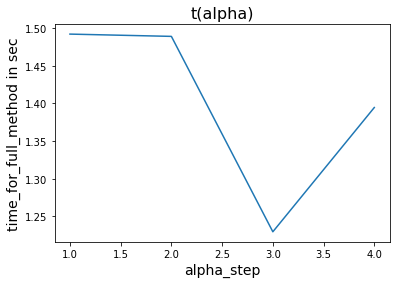

In [27]:
plt.plot(accuracy_results[accuracy_results['beta_step'] == 2]['alpha_step'], 
         accuracy_results[accuracy_results['beta_step'] == 2]['time_for_full_method'])
plt.title('t(alpha)', fontsize=16)
plt.xlabel("alpha_step", fontsize=14)
plt.ylabel("time_for_full_method in sec", fontsize=14)
plt.show()

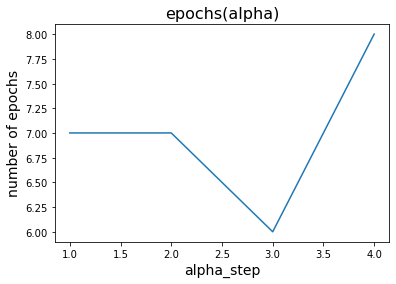

In [62]:
plt.plot(accuracy_results[accuracy_results['beta_step'] == 2]['alpha_step'], 
         accuracy_results[accuracy_results['beta_step'] == 2]['number_of_epochs'])
plt.title('epochs(alpha)', fontsize=16)
plt.xlabel("alpha_step", fontsize=14)
plt.ylabel("number of epochs", fontsize=14)
plt.show()

Зафиксируем значение параметра alpha и построим графики зависимости времени/количетва эпох от beta 

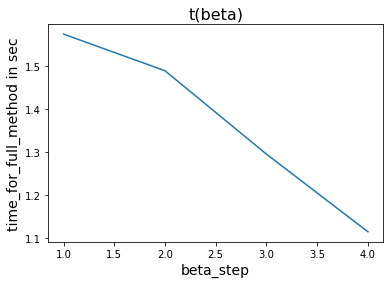

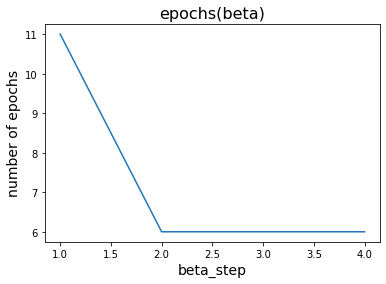

In [63]:
plt.plot(accuracy_results[accuracy_results['alpha_step'] == 2]['beta_step'], 
         accuracy_results[accuracy_results['alpha_step'] == 2]['time_for_full_method'])
plt.title('t(beta)', fontsize=16)
plt.xlabel("beta_step", fontsize=14)
plt.ylabel("time_for_full_method in sec", fontsize=14)
plt.show()

plt.plot(accuracy_results[accuracy_results['alpha_step'] == 3]['beta_step'], 
         accuracy_results[accuracy_results['alpha_step'] == 3]['number_of_epochs'])
plt.title('epochs(beta)', fontsize=16)
plt.xlabel("beta_step", fontsize=14)
plt.ylabel("number of epochs", fontsize=14)
plt.show()

In [32]:
np.all(np.equal(accuracy_results.sort_values(by = ['balanced_accuracy_val'], ascending = False).index,
       accuracy_results.sort_values(by = ['balanced_accuracy_train'], ascending = False).index))

True

Заметим, что порядок при сортировке по balanced_accuracy на train и по balanced_accuracy на val сопадает, поэтому однозначно можем выбрать лучшую пару параметров alpha_step и beta_step для обеих выборок.

In [33]:
accuracy_results.sort_values(by = ['balanced_accuracy_val'], ascending = False).head(10)

,alpha_step,beta_step,balanced_accuracy_train,balanced_accuracy_val,time_for_full_method,number_of_epochs
8,3,1,0.874827,0.870319,1.941660,11
4,2,1,0.789800,0.792768,1.574201,8
13,4,2,0.770872,0.774746,1.394412,8
14,4,3,0.751246,0.754163,1.217411,4
9,3,2,0.746046,0.750068,1.229235,6
0,1,1,0.726252,0.729734,1.445586,7
12,4,1,0.719633,0.715858,2.482116,14
5,2,2,0.705915,0.708339,1.488983,7
1,1,2,0.686866,0.687642,1.492012,7
10,3,3,0.680410,0.681697,1.312272,6


Отсортируем методы по ремени работы методов.

In [34]:
accuracy_results.sort_values(by = ['time_for_full_method']).head(10)

,alpha_step,beta_step,balanced_accuracy_train,balanced_accuracy_val,time_for_full_method,number_of_epochs
3,1,4,0.656169,0.656667,0.986663,4
7,2,4,0.656775,0.657745,1.114404,5
2,1,3,0.660910,0.661889,1.126931,5
14,4,3,0.751246,0.754163,1.217411,4
9,3,2,0.746046,0.750068,1.229235,6
11,3,4,0.657555,0.658811,1.231178,6
6,2,3,0.665360,0.667226,1.294983,6
10,3,3,0.680410,0.681697,1.312272,6
13,4,2,0.770872,0.774746,1.394412,8
0,1,1,0.726252,0.729734,1.445586,7


Посмотрим на зависимость функции потерь от эпохи для каждой пары параметров.

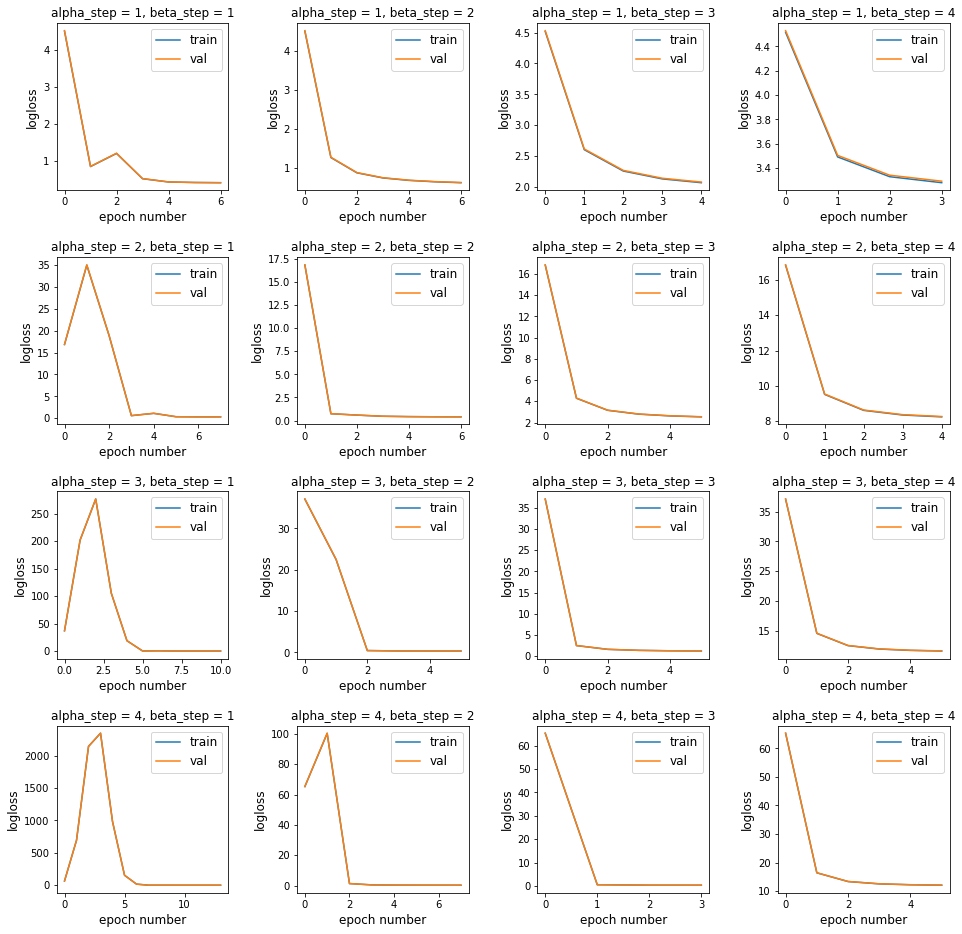

In [35]:
plt.figure(figsize=(16,16))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
for i in range(len(hist)):
    plt.subplot(4,4,i+1)
    plt.plot(np.arange(len(hist[i]['func'])), hist[i]['func'], label="train")
    plt.plot(np.arange(len(hist[i]['func_val'])), hist[i]['func_val'], label="val")
    plt.title('alpha_step = '+str(alpha_for_results[i]) + ', beta_step = ' + str(beta_for_results[i]), fontsize=12)
    plt.legend(fontsize=12)
    plt.xlabel("epoch number", fontsize=12)
    plt.ylabel("logloss", fontsize=12)
    
    
plt.show()

Посмотрим на зависимость функции потерь от суммарного времени работы эпох.

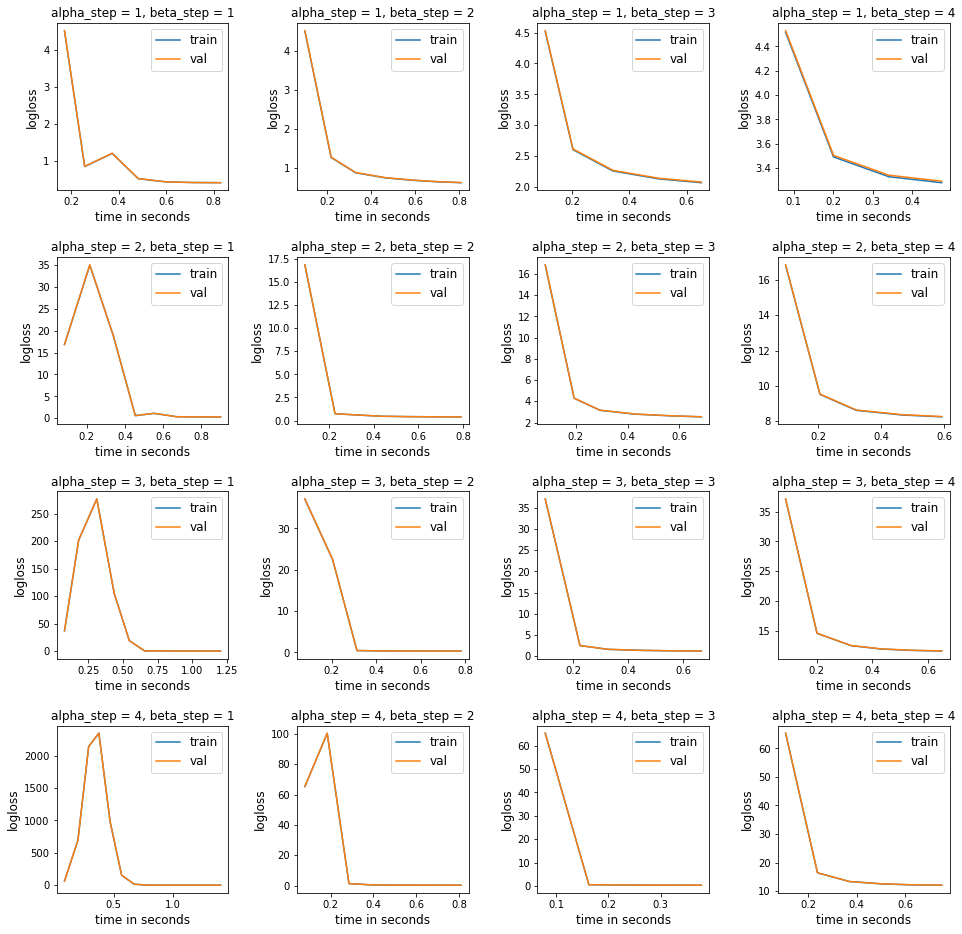

In [36]:
plt.figure(figsize=(16,16))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
for i in range(len(hist)):
    plt.subplot(4,4,i+1)
    plt.plot(np.cumsum(hist[i]['time']), hist[i]['func'], label="train")
    plt.plot(np.cumsum(hist[i]['time']), hist[i]['func_val'], label="val")
    plt.title('alpha_step = '+str(alpha_for_results[i]) + ', beta_step = ' + str(beta_for_results[i]), fontsize=12)
    plt.legend(fontsize=12)
    plt.xlabel("time in seconds", fontsize=12)
    plt.ylabel("logloss", fontsize=12)
    
    
plt.show()

Видим, что значения logloss для train и val на графике совсем не различимы. Это свидетельствует об однородности данных и о том, что переобучение практически отсутствует. Что мы уже наблюдали при подсчёте метрик. 

#### Ответьте на следующие вопросы

1. По результатам экспериментов, какие параметры `step_alpha` и `step_beta` вы считаете наиболее оптимальными? Если пар оптимальных параметров получилось несколько, какую пару вы выберете для дальнейших экпериментов и почему?

    По результатам экспериментов наиболее оптимальными я считаю параметры `step_alpha` и `step_beta`, равные 3 и 1. Для этой пары значения balanced accuracy как на train, так и на val были самыми высокими. Даже несмотря на то, что метод с этими параметрами работал довольно долго относительно остальных(но не больше, чпем в два раза дольше лучшего). однако сам logloss, судя по графику, падал довольно быстро до значения, близкого к минимуму. Если бы результаты balanced accuracy на других парах были сопоставимы с результатами для пары (3,1), то я бы смотрел на время сходимости и на сами графики сходимости(скорость сходимости).  
    


2. Какие зависимости между параметрами `step_alpha`/`step_beta` и временем работы алгоритма/кол-ва эпох вы наблюдаете? Опишите свои наблюдения.

    При фиксированном `step_alpha` и при увеличении `step_beta` время работы алгоритма уменьшается, количество эпох почти всегда не увеличивается. При фиксированном `step_beta` монотонной зависимости по `step_alpha` не налюдается, однако точно можно сказать, что при больших `step_beta` среднее время для всех `step_alpha` уменьшается, как и среднее количество эпох. Сами зависимости представлены на графиках выше.
    
    
3. Поясните, в чём преимущество использования balanced accuracy для этой задачи по сравнению с обычной accuracy?

    В нашем случае выборка не сбалансированы, негативных отзывов в 10 раз больше, чем позитивных. Таким образом, если бы мы всем отзывам присвоили значение -1, то получили бы accuracy примерно 0.91, оэто значение бы никак не отражало качество модели.

### 2. Исследование параметров стахастического градиентного спуска (3 балла)
Исследуйте поведение стохастического градиентного спуска для задачи логистической регрессии в зависимости от следующих параметров:

- параметр темпа обучения `step_alpha`
- параметр темпа обучения `step_beta`
- размер подвыборки `batch_size`

**Замечание.** Обратите внимание, что в стохастическом случае необходимо строить зависимости метрик качества от эпохи метода. За одну эпоху через оптимизацию модели проходит $N$ объектов, где $N$ — длина обучающей выборки. Если вы реализуете семплирование согласно спецификации задания, то за одну эпоху каждый объект пройдёт через оптимизацию ровно один раз. В полном градиентном спуске одна эпоха метода соответствует одной итерации обучения.

In [37]:
loss_function = BinaryLogisticLoss(l2_coef=1.0)

beta_grid = np.arange(1,5)
alpha_grid = np.arange(1,5)
batch_size_grid = np.array([20000, 30000, 50000])
hist = []
balanced_accuracy_train = []
balanced_accuracy_val = []

In [38]:
%%time
i = 0
time_for_full_method = []
for element in tqdm(itertools.product(alpha_grid, beta_grid, batch_size_grid)):
    step_alpha, step_beta, batch_size = element
    call_method(loss_function, step_alpha, step_beta, batch_size) 
    time_for_full_method.append(np.sum(hist[i]['time'])) 
    i+=1

48it [04:50,  6.06s/it]

Wall time: 4min 50s


In [39]:
alpha_for_results = []
beta_for_results = []
batch_size_for_results = []
number_of_epochs = []
i = 0
for element in itertools.product(alpha_grid, beta_grid, batch_size_grid):
    step_alpha, step_beta, batch_size = element
    alpha_for_results.append(step_alpha)
    beta_for_results.append(step_beta)
    batch_size_for_results.append(batch_size)
    number_of_epochs.append(len(hist[i]['func']))
    i+=1

#### Приведите график / таблицу с результатами ваших экспериментов

In [40]:
accuracy_results_stoch_grad_desc = pd.DataFrame({'alpha_step': alpha_for_results,
                             'beta_step': beta_for_results,
                             'batch_size': batch_size_for_results,
                             'balanced_accuracy_train': balanced_accuracy_train,
                             'balanced_accuracy_val': balanced_accuracy_val,
                             'time_for_full_method': time_for_full_method,
                             'number_of_epochs': number_of_epochs})

In [41]:
accuracy_results_stoch_grad_desc.head(10)

,alpha_step,beta_step,batch_size,balanced_accuracy_train,balanced_accuracy_val,time_for_full_method,number_of_epochs
0,1,1,20000,0.873980,0.868568,4.542038,9
1,1,1,30000,0.829136,0.827870,2.908248,7
2,1,1,50000,0.796973,0.799273,3.261413,9
3,1,2,20000,0.874375,0.868470,1.896101,4
4,1,2,30000,0.809762,0.811222,1.542416,4
5,1,2,50000,0.757426,0.761199,2.040115,6
6,1,3,20000,0.800747,0.799152,1.951109,4
7,1,3,30000,0.782781,0.780535,1.978084,5
8,1,3,50000,0.644602,0.643471,2.771512,8
9,1,4,20000,0.501745,0.501965,3.679440,7


Отсортируем по точности на валидационной выборке.

In [42]:
accuracy_results_stoch_grad_desc.sort_values(by = ['balanced_accuracy_val'], ascending = False).head(10)

,alpha_step,beta_step,batch_size,balanced_accuracy_train,balanced_accuracy_val,time_for_full_method,number_of_epochs
17,2,2,50000,0.874488,0.869761,1.282281,5
0,1,1,20000,0.873980,0.868568,4.542038,9
3,1,2,20000,0.874375,0.868470,1.896101,4
16,2,2,30000,0.863831,0.856947,1.485868,5
1,1,1,30000,0.829136,0.827870,2.908248,7
4,1,2,30000,0.809762,0.811222,1.542416,4
2,1,1,50000,0.796973,0.799273,3.261413,9
6,1,3,20000,0.800747,0.799152,1.951109,4
7,1,3,30000,0.782781,0.780535,1.978084,5
5,1,2,50000,0.757426,0.761199,2.040115,6


Отсортируем по общему времени работы метода

In [43]:
accuracy_results_stoch_grad_desc.sort_values(by = ['time_for_full_method']).head(10)

,alpha_step,beta_step,batch_size,balanced_accuracy_train,balanced_accuracy_val,time_for_full_method,number_of_epochs
44,4,3,50000,0.642043,0.635029,1.061309,4
43,4,3,30000,0.635270,0.628058,1.191954,4
17,2,2,50000,0.874488,0.869761,1.282281,5
36,4,1,20000,0.500152,0.500659,1.408713,4
31,3,3,30000,0.587811,0.584511,1.460387,5
16,2,2,30000,0.863831,0.856947,1.485868,5
4,1,2,30000,0.809762,0.811222,1.542416,4
29,3,2,50000,0.648232,0.640140,1.790621,7
42,4,3,20000,0.572014,0.566929,1.844505,5
3,1,2,20000,0.874375,0.868470,1.896101,4


Отсортируем по количеству эпох

In [67]:
accuracy_results_stoch_grad_desc.sort_values(by = ['number_of_epochs']).head(10)

,alpha_step,beta_step,batch_size,balanced_accuracy_train,balanced_accuracy_val,time_for_full_method,number_of_epochs
43,4,3,30000,0.635270,0.628058,1.191954,4
44,4,3,50000,0.642043,0.635029,1.061309,4
3,1,2,20000,0.874375,0.868470,1.896101,4
4,1,2,30000,0.809762,0.811222,1.542416,4
36,4,1,20000,0.500152,0.500659,1.408713,4
6,1,3,20000,0.800747,0.799152,1.951109,4
31,3,3,30000,0.587811,0.584511,1.460387,5
7,1,3,30000,0.782781,0.780535,1.978084,5
17,2,2,50000,0.874488,0.869761,1.282281,5
16,2,2,30000,0.863831,0.856947,1.485868,5


Посмотрим на зависимость функции потерь от эпохи для каждой тройки параметров.

Построим графики для 12 лучшех моделей по точности на валидационной выборке

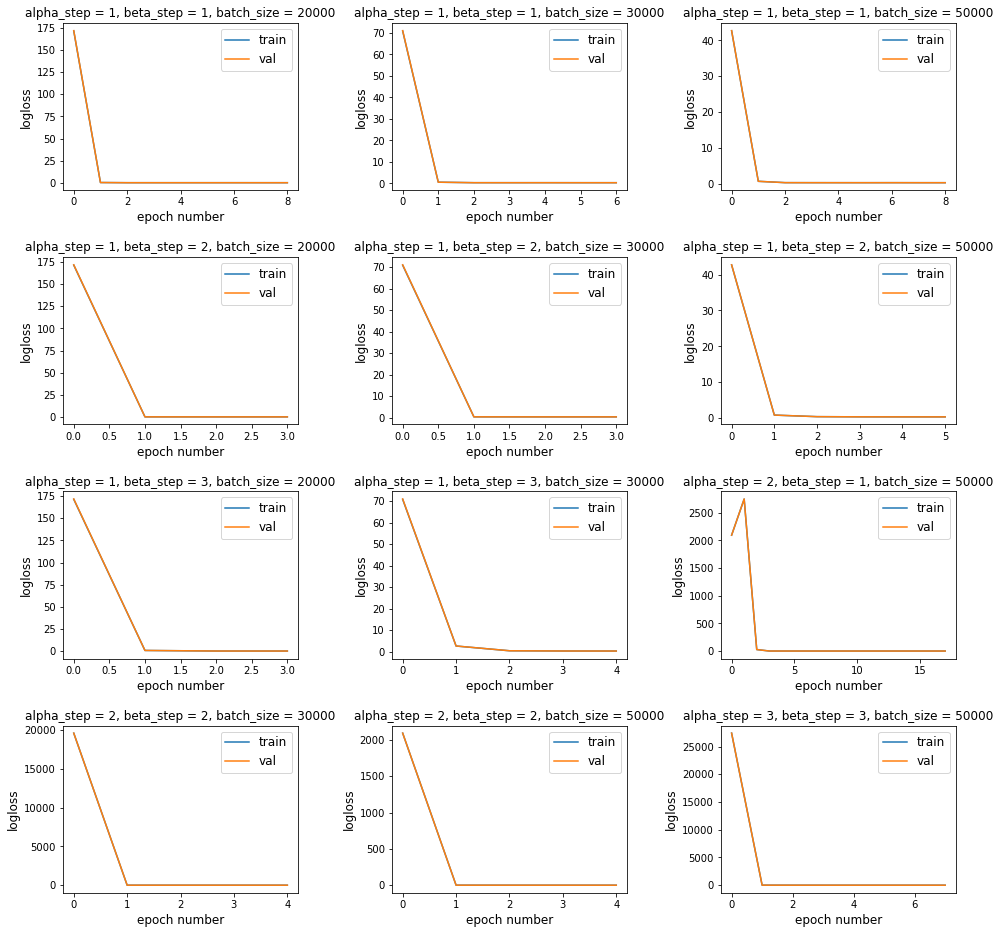

In [44]:
plt.figure(figsize=(16,16))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
j = 0
for i in range(len(hist)):
    if i in accuracy_results_stoch_grad_desc.sort_values(by = ['balanced_accuracy_val'], ascending = False).index[:12]:
        plt.subplot(4,3,j+1)
        plt.plot(np.arange(len(hist[i]['func'])), hist[i]['func'], label="train")
        plt.plot(np.arange(len(hist[i]['func_val'])), hist[i]['func_val'], label="val")
        plt.title('alpha_step = '+str(alpha_for_results[i]) + ', beta_step = ' + str(beta_for_results[i]) + 
                  ', batch_size = ' + str(batch_size_for_results[i]), fontsize=12)
        plt.legend(fontsize=12)
        plt.xlabel("epoch number", fontsize=12)
        plt.ylabel("logloss", fontsize=12)
        j+=1
    
    
plt.show()

Посмотрим на зависимость функции потерь от суммарного времени работы эпох.

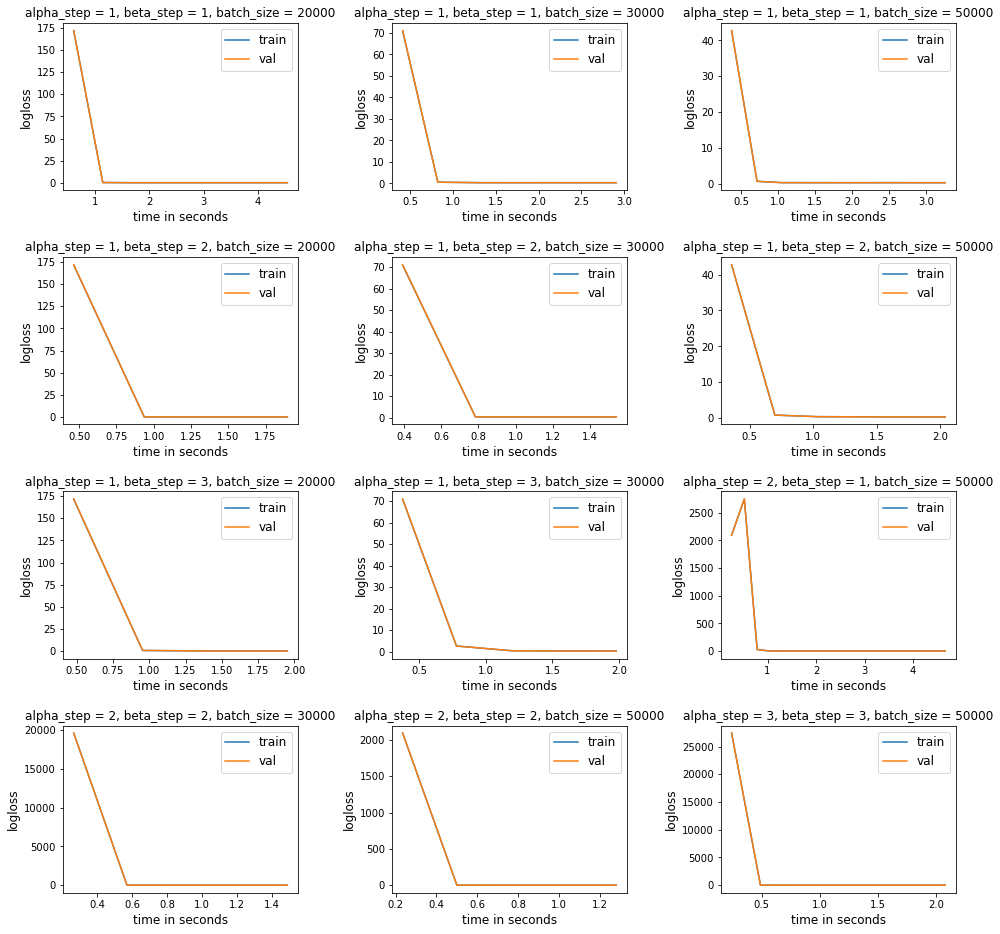

In [45]:
plt.figure(figsize=(16,16))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
j = 0
for i in range(len(hist)):
    if i in accuracy_results_stoch_grad_desc.sort_values(by = ['balanced_accuracy_val'], ascending = False).index[:12]:
        plt.subplot(4,3,j+1)
        plt.plot(np.cumsum(hist[i]['time']), hist[i]['func'], label="train")
        plt.plot(np.cumsum(hist[i]['time']), hist[i]['func_val'], label="val")
        plt.title('alpha_step = '+str(alpha_for_results[i]) + ', beta_step = ' + str(beta_for_results[i]) + 
                  ', batch_size = ' + str(batch_size_for_results[i]), fontsize=12)
        plt.legend(fontsize=12)
        plt.xlabel("time in seconds", fontsize=12)
        plt.ylabel("logloss", fontsize=12)
        j+=1
    
    
plt.show()

Снова видим, что значения logloss для train и val на графике совсем не различимы. Они не одинаковы,  это было проверено. Это свидетельствует об однородности данных и о том, что переобучение практически отсутствует. Что мы уже наблюдали при подсчёте метрик.

Посмотрим, как меняется время работы метода/количество эпох при фиксировании двух параметров и изменении третьего

In [60]:
accuracy_results_stoch_grad_desc

,alpha_step,beta_step,batch_size,balanced_accuracy_train,balanced_accuracy_val,time_for_full_method,number_of_epochs
0,1,1,20000,0.873980,0.868568,4.542038,9
1,1,1,30000,0.829136,0.827870,2.908248,7
2,1,1,50000,0.796973,0.799273,3.261413,9
3,1,2,20000,0.874375,0.868470,1.896101,4
4,1,2,30000,0.809762,0.811222,1.542416,4
5,1,2,50000,0.757426,0.761199,2.040115,6
6,1,3,20000,0.800747,0.799152,1.951109,4
7,1,3,30000,0.782781,0.780535,1.978084,5
8,1,3,50000,0.644602,0.643471,2.771512,8
9,1,4,20000,0.501745,0.501965,3.679440,7


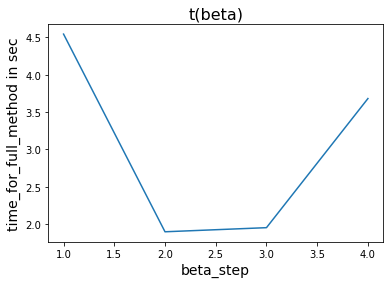

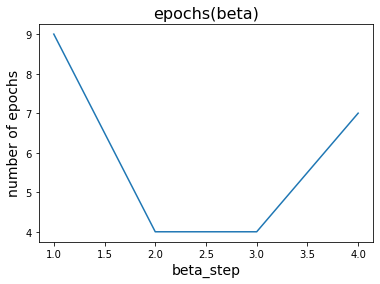

In [64]:
plt.plot(accuracy_results_stoch_grad_desc[(accuracy_results_stoch_grad_desc['alpha_step'] == 1) & 
                                 (accuracy_results_stoch_grad_desc['batch_size'] == 20000)]['beta_step'], 
         accuracy_results_stoch_grad_desc[(accuracy_results_stoch_grad_desc['alpha_step'] == 1) & 
                                 (accuracy_results_stoch_grad_desc['batch_size'] == 20000)]['time_for_full_method'])
plt.title('t(beta)', fontsize=16)
plt.xlabel("beta_step", fontsize=14)
plt.ylabel("time_for_full_method in sec", fontsize=14)
plt.show()

plt.plot(accuracy_results_stoch_grad_desc[(accuracy_results_stoch_grad_desc['alpha_step'] == 1) & 
                                 (accuracy_results_stoch_grad_desc['batch_size'] == 20000)]['beta_step'], 
         accuracy_results_stoch_grad_desc[(accuracy_results_stoch_grad_desc['alpha_step'] == 1) & 
                                 (accuracy_results_stoch_grad_desc['batch_size'] == 20000)]['number_of_epochs'])
plt.title('epochs(beta)', fontsize=16)
plt.xlabel("beta_step", fontsize=14)
plt.ylabel("number of epochs", fontsize=14)
plt.show()

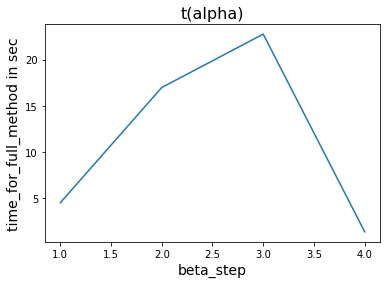

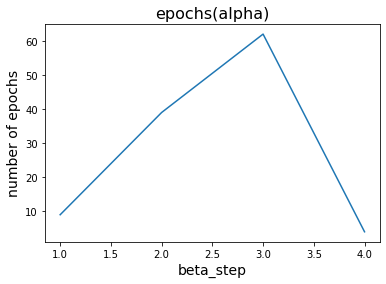

In [65]:
plt.plot(accuracy_results_stoch_grad_desc[(accuracy_results_stoch_grad_desc['beta_step'] == 1) & 
                                 (accuracy_results_stoch_grad_desc['batch_size'] == 20000)]['alpha_step'], 
         accuracy_results_stoch_grad_desc[(accuracy_results_stoch_grad_desc['beta_step'] == 1) & 
                                 (accuracy_results_stoch_grad_desc['batch_size'] == 20000)]['time_for_full_method'])
plt.title('t(alpha)', fontsize=16)
plt.xlabel("beta_step", fontsize=14)
plt.ylabel("time_for_full_method in sec", fontsize=14)
plt.show()

plt.plot(accuracy_results_stoch_grad_desc[(accuracy_results_stoch_grad_desc['beta_step'] == 1) & 
                                 (accuracy_results_stoch_grad_desc['batch_size'] == 20000)]['alpha_step'], 
         accuracy_results_stoch_grad_desc[(accuracy_results_stoch_grad_desc['beta_step'] == 1) & 
                                 (accuracy_results_stoch_grad_desc['batch_size'] == 20000)]['number_of_epochs'])
plt.title('epochs(alpha)', fontsize=16)
plt.xlabel("beta_step", fontsize=14)
plt.ylabel("number of epochs", fontsize=14)
plt.show()

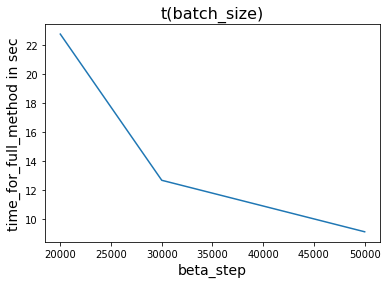

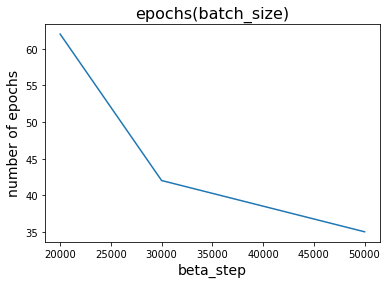

In [66]:
plt.plot(accuracy_results_stoch_grad_desc[(accuracy_results_stoch_grad_desc['beta_step'] == 1) & 
                                 (accuracy_results_stoch_grad_desc['alpha_step'] == 3)]['batch_size'], 
         accuracy_results_stoch_grad_desc[(accuracy_results_stoch_grad_desc['beta_step'] == 1) & 
                                 (accuracy_results_stoch_grad_desc['alpha_step'] == 3)]['time_for_full_method'])
plt.title('t(batch_size)', fontsize=16)
plt.xlabel("beta_step", fontsize=14)
plt.ylabel("time_for_full_method in sec", fontsize=14)
plt.show()

plt.plot(accuracy_results_stoch_grad_desc[(accuracy_results_stoch_grad_desc['beta_step'] == 1) & 
                                 (accuracy_results_stoch_grad_desc['alpha_step'] == 3)]['batch_size'], 
         accuracy_results_stoch_grad_desc[(accuracy_results_stoch_grad_desc['beta_step'] == 1) & 
                                 (accuracy_results_stoch_grad_desc['alpha_step'] == 3)]['number_of_epochs'])
plt.title('epochs(batch_size)', fontsize=16)
plt.xlabel("beta_step", fontsize=14)
plt.ylabel("number of epochs", fontsize=14)
plt.show()

#### Ответьте на следующие вопросы

1. По результатам экспериментов, какие параметры `step_alpha`, `step_beta` и `batch_size` вы считаете наиболее оптимальными? Если троек оптимальных параметров получилось несколько, какую пару вы выберете для дальнейших экпериментов и почему?

    По результатам экспериментов наиболее оптимальными я считаю параметры `step_alpha`, `step_beta` и `batch_size`, равные 2, 2 и 50000. Для этой тройки значения balanced accuracy как на train, так и на val были самыми высокими. Также метод с этими параметрами попал в топ-3 по общему времени работы и оказался луше по этому показателя среди моделей со сравнимым качеством. Сам logloss, судя по графику, падал довольно быстро до значения, близкого к минимуму. Результаты balanced accuracy на некоторых тройках оказались сопоставимы с результатами для выбранной. Я выбрал эту тройку, так у неё наименьшее время работы и количество эпох по сравнению с остальными претендентами на оптимальность.
  

2. Какие зависимости между параметрами `step_alpha`/`step_beta`/`batch_size` и временем работы алгоритма/кол-ва эпох вы наблюдаете? 

    Зависимость суммарного времени работы алгоритма и количество эпох от `step_beta` согласно графикам имеет явную точку минимум, а зависимость суммарного времени работы алгоритма и количество эпох от `step_alpha` согласно графикам имеет явную точку максимума. 

    При фиксированных `step_alpha`, `step_beta` и увеличении `batch_size` время работы алгоритма и количество эпох почти всегда уменьшалось. ЧТо вполне естественно, т.к. при этом меньше итераций делаем в цикле по обучающей выборке.

Посмотрим, какие значения принимал learning rate на каждой эпохе в случае полного градиентного спуска и стохастического для лучших параметров.

In [85]:
best_full_gr_de = accuracy_results.sort_values(by = ['balanced_accuracy_val'], ascending = False).iloc[:5]
for i in range(5):
    a = np.arange(1, best_full_gr_de['number_of_epochs'].values[i]+1)
    print('number_of_epochs: ', best_full_gr_de['number_of_epochs'].values[i])
    for j in a:
        print(best_full_gr_de['alpha_step'].values[i]/(j**best_full_gr_de['beta_step'].values[i]))

number_of_epochs:  11
3.0
1.5
1.0
0.75
0.6
0.5
0.42857142857142855
0.375
0.3333333333333333
0.3
0.2727272727272727
number_of_epochs:  8
2.0
1.0
0.6666666666666666
0.5
0.4
0.3333333333333333
0.2857142857142857
0.25
number_of_epochs:  8
4.0
1.0
0.4444444444444444
0.25
0.16
0.1111111111111111
0.08163265306122448
0.0625
number_of_epochs:  4
4.0
0.5
0.14814814814814814
0.0625
number_of_epochs:  6
3.0
0.75
0.3333333333333333
0.1875
0.12
0.08333333333333333


In [86]:
best_stoch_gr_de = accuracy_results_stoch_grad_desc.sort_values(by = ['balanced_accuracy_val'], ascending = False).iloc[:5]
for i in range(5):
    a = np.arange(1, best_stoch_gr_de['number_of_epochs'].values[i]+1)
    print('number_of_epochs: ', best_stoch_gr_de['number_of_epochs'].values[i])
    for j in a:
        print(best_stoch_gr_de['alpha_step'].values[i]/(j**best_stoch_gr_de['beta_step'].values[i]))

number_of_epochs:  5
2.0
0.5
0.2222222222222222
0.125
0.08
number_of_epochs:  9
1.0
0.5
0.3333333333333333
0.25
0.2
0.16666666666666666
0.14285714285714285
0.125
0.1111111111111111
number_of_epochs:  4
1.0
0.25
0.1111111111111111
0.0625
number_of_epochs:  5
2.0
0.5
0.2222222222222222
0.125
0.08
number_of_epochs:  7
1.0
0.5
0.3333333333333333
0.25
0.2
0.16666666666666666
0.14285714285714285


### 3. Сравнение двух методов (2 балла)
Сравните поведение двух методов между собой, и ответьте на следующие вопросы

1. Какой алгоритм вы выберете для дальнейших экспериментов и почему?

    Для дальнейших экспериментов я выберу алгоритм со стохастичим градиентным спуском и параметрами `step_alpha`, `step_beta` и `batch_size`, равными 2, 2 и 50000, так как по точности лучшие алгоритмы были почти равны, но при использовании стохастического градиентного спуска получилось меньше эпох и меньшее общее время работы алгоритма. Также потому что для стохастического градиентного спуска было несколько троек параметров, имеющих близкие к оптимальному значения точности, а дальше наблюдается постепенное уменьшение точности. При использовании полного градиентого спуска пару оптимальных параметров можно считать выбросом по показателям точности, так что надеяться на такую же точность для дальнейших экспериментов не приходится. 
    

2. Есть ли разница между парами оптимальных параметров `step_alpha` и `step_beta` в двух алгоритмах? Объясните разницу/отсутствие разницы в результатах.

    Да, есть разница между парами оптимальных параметров `step_alpha` и `step_beta`. Согласно приведённым выше результатам можно выделить следующую особенность: `learning_rate` для стохастического градиентого спуска лучше брать меньше, чем для полного. 

### 4. Регуляризация (2 балла)
Подберите по отложенной выборке коэффициент $l2$-регуляризации модели. 

Приведите график с результатами ваших экспериментов. Обоснуйте свой выбор.

In [126]:
tolerance = 1e-3
max_iter = 250
step_alpha = 2
step_beta = 2 
batch_size = 50000

In [116]:
l2_grid = np.arange(0,2.1, 0.1)
hist = []
balanced_accuracy_train = []
balanced_accuracy_val = []
number_of_epochs = []
time_for_full_method = []

In [117]:
for i in tqdm(range(len(l2_grid))):
    loss_function = BinaryLogisticLoss(l2_coef=l2_grid[i])
    call_method(loss_function, step_alpha, step_beta, batch_size) 
    time_for_full_method.append(np.sum(hist[i]['time'])) 
    number_of_epochs.append(len(hist[i]['func']))

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:55<00:00,  2.63s/it]


In [118]:
accuracy_results_l2_reg = pd.DataFrame({'l2_coeff': l2_grid,
                             'balanced_accuracy_train': balanced_accuracy_train,
                             'balanced_accuracy_val': balanced_accuracy_val,
                             'time_for_full_method': time_for_full_method,
                             'number_of_epochs': number_of_epochs})

In [121]:
accuracy_results_l2_reg.sort_values(by = ['balanced_accuracy_val'], ascending = False).head()

,l2_coeff,balanced_accuracy_train,balanced_accuracy_val,time_for_full_method,number_of_epochs
8,0.8,0.877242,0.870811,1.299023,5
10,1.0,0.874488,0.869761,1.307735,5
9,0.9,0.876509,0.869681,1.300391,5
6,0.6,0.874116,0.868961,1.718164,6
7,0.7,0.876723,0.868863,1.360168,5


Попробуем точнее найти оптимум. Выберем более мелкую сетку в окрестности найденных оптимальных значений

In [130]:
l2_grid = np.arange(0.8,1.01, 0.01)
hist = []
balanced_accuracy_train = []
balanced_accuracy_val = []
number_of_epochs = []
time_for_full_method = []

In [131]:
for i in tqdm(range(len(l2_grid))):
    loss_function = BinaryLogisticLoss(l2_coef=l2_grid[i])
    call_method(loss_function, step_alpha, step_beta, batch_size) 
    time_for_full_method.append(np.sum(hist[i]['time'])) 
    number_of_epochs.append(len(hist[i]['func']))

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:51<00:00,  2.45s/it]


In [132]:
accuracy_results_l2_reg = pd.DataFrame({'l2_coeff': l2_grid,
                             'balanced_accuracy_train': balanced_accuracy_train,
                             'balanced_accuracy_val': balanced_accuracy_val,
                             'time_for_full_method': time_for_full_method,
                             'number_of_epochs': number_of_epochs})

In [133]:
accuracy_results_l2_reg.sort_values(by = ['balanced_accuracy_val'], ascending = False).head()

,l2_coeff,balanced_accuracy_train,balanced_accuracy_val,time_for_full_method,number_of_epochs
2,0.82,0.877270,0.870995,1.623821,5
15,0.95,0.876790,0.870894,1.268380,5
0,0.80,0.877242,0.870811,1.548047,5
3,0.83,0.877183,0.870763,1.440512,5
1,0.81,0.877376,0.870752,1.437986,5


Построим график зависимости точности на валидационной выборке от коэффициента l2-регуляризации.

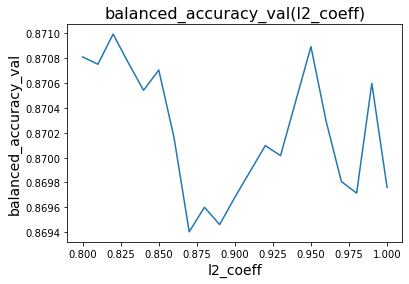

In [136]:
plt.plot(accuracy_results_l2_reg['l2_coeff'], 
         accuracy_results_l2_reg['balanced_accuracy_val'])
plt.title('balanced_accuracy_val(l2_coeff)', fontsize=16)
plt.xlabel("l2_coeff", fontsize=14)
plt.ylabel("balanced_accuracy_val", fontsize=14)
plt.show()

Построим график зависимости времени работы и количества эпох от коэффициента l2-регуляризации.

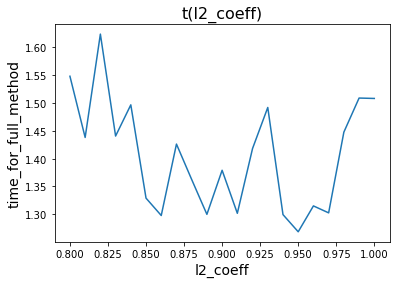

In [137]:
plt.plot(accuracy_results_l2_reg['l2_coeff'], 
         accuracy_results_l2_reg['time_for_full_method'])
plt.title('t(l2_coeff)', fontsize=16)
plt.xlabel("l2_coeff", fontsize=14)
plt.ylabel("time_for_full_method", fontsize=14)
plt.show()

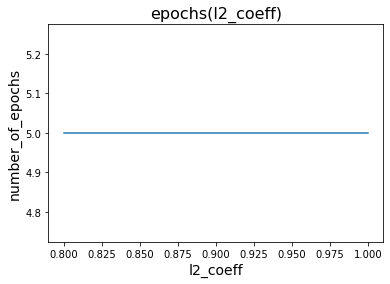

In [138]:
plt.plot(accuracy_results_l2_reg['l2_coeff'], 
         accuracy_results_l2_reg['number_of_epochs'])
plt.title('epochs(l2_coeff)', fontsize=16)
plt.xlabel("l2_coeff", fontsize=14)
plt.ylabel("number_of_epochs", fontsize=14)
plt.show()

Заметим, что в выбранных пределах коэффициента l2-регуляризации значение числа эпох было одинаковым для всех моделей.

Выберем в качестве оптимального коэффициента регуляризации значения $0.95$, так как по точности он почти не отличается от лучшего, но по времени работы значительно превосходит остальные.

### 5. Измерение качества и интерпретация результатов (3 балла)
Выберите лучший алгоритм для тестовой выборки. Обратите внимание, что необходимо использовать порог бинаризации, выбранный на отложенной выборке.

In [161]:
tolerance = 1e-3
max_iter = 250
step_alpha = 2
step_beta = 2 
batch_size = 50000
loss_function = BinaryLogisticLoss(l2_coef=0.95)

In [162]:
lm = LinearModel(loss_function=loss_function, batch_size=batch_size, step_alpha=step_alpha, step_beta=step_beta,
                     tolerance=tolerance, max_iter=max_iter)
lm.fit(X_train, y_train.values)
optimal_threshold_train = lm.get_optimal_threshold(X_train, y_train.values)
# параметр порог бинаризации для тестовой выборки выбирается по валидационной выборке
optimal_threshold_val = lm.get_optimal_threshold(X_val, y_val.values) 

In [163]:
y_pred_train = lm.predict(X_train, optimal_threshold_train)
y_pred_val = lm.predict(X_val, optimal_threshold_train)
y_pred_test = lm.predict(X_test, optimal_threshold_val)

In [171]:
print('balanced_accuracy_train: ',"%.4f" % compute_balanced_accuracy(y_train.values, y_pred_train))
print('balanced_accuracy_val: ',"%.4f" % compute_balanced_accuracy(y_val.values, y_pred_val))
print('balanced_accuracy_test: ',"%.4f" % compute_balanced_accuracy(y_test.values, y_pred_test))

balanced_accuracy_train:  0.8768
balanced_accuracy_val:  0.8709
balanced_accuracy_test:  0.8637


#### Ответьте на следующие вопросы

1. Примените лучший алгоритм к тестовой выборке и посмотрите на метрику качества. Сравните ее с метрикой на валидации. Опишите ваши наблюдения.

    Как и ожидалось, значение выбранной метрики немного падает. Больше всего результат на train, затем на val и затем на test. Значение метрики на тестовой выборке немного меньше, чем на валидационной, так как выборали оптималные параметры, максимизируя значение метрики на валидационной выборке. Так в тестовой выборке всё же немного другие, то значение метрики на на ней будет меньше. Стоит отметить, что все три значения почти не отличаются, так что переобучение практически отсутствует. 

2. Проанализируйте ошибки алгоритма. Проанализируйте и укажите общие черты объектов, на которых были допущены ошибки. Наблюдения опишите.

    Модель в основном ошибалась в тех местах, где и человеку сложно понять по отзыву, токсичный он или нет, в местах, где были допущены орфографические ошибки в значимых словах, а также в текстах, где 'положительные' или 'негативные' слова употреблялись в противоположном значении(сарказм и т.д.)


Посмотрим на матрицу ошибок

In [174]:
confusion_matrix(y_test.values, y_pred_test) 

array([[47104, 10631],
       [  552,  5691]], dtype=int64)

Посмотрим, на каких текстах были допушены ошибки.

False Negative

In [202]:
print(test['comment_text'].iloc[618])
print(test['preprocessed_comment'].iloc[618])
print('true: ', test['is_toxic'].iloc[618])
print('pred: ', y_pred_test[618])

Shut up please, this consensus is over.
shut please consensus over
true:  1
pred:  -1.0


In [210]:
print(test['comment_text'].iloc[800])
print(test['preprocessed_comment'].iloc[800])
print('true: ', test['is_toxic'].iloc[800])
print('pred: ', y_pred_test[800])

== wtf == 

 whoever removed all the great images on here should be shot dead and have their corpse raped. one of them was so nice i made it my backround
wtf whoever removed great image shot dead corpse raped one nice made backround
true:  1
pred:  -1.0


False Positive

In [216]:
print(test['comment_text'].iloc[1])
print(test['preprocessed_comment'].iloc[1])
print('true: ', test['is_toxic'].iloc[1])
print('pred: ', y_pred_test[1])

:Dear god this site is horrible.
dear god site horrible
true:  -1
pred:  1.0


In [219]:
print(test['comment_text'].iloc[9])
print(test['preprocessed_comment'].iloc[9])
print('true: ', test['is_toxic'].iloc[9])
print('pred: ', y_pred_test[9])

Please stop. If you continue to vandalize Wikipedia, as you did to Homosexuality, you will be blocked from editing.
please stop continue vandalize wikipedia homosexuality blocked editing
true:  -1
pred:  1.0


3. Проинтерпретируйте линейные коэффициенты признаков. Выберите коэффициенты с набиольшим значением и коэффициенты с наименьшим значением. Проанализируйте, каким словам они соответствуют. Согласуются ли ваши наблюдения с вашими ожиданиями от модели?

    *ваш ответ*

## Бонусная часть
В бонусной части предлагается решить более сложную задачу — нужно не просто определить токсичное сообщение или нет, а понять тип токсичности. По сути вам нужно решить задачу классификации на $5$ классов: `insult`, `obscene`, `obscene_and_insult`, `no_obscene_no_insult` и `not_toxic`. Все новые целевые переменные записаны в соответствующих столбцах, `not_toxic` можно получить инвертировав столбец `is_toxic`.

### 1. Теоретическая часть (1 балл)
Выведите формулу градиента функции потерь для задачи мультиномиальной регресии. Запишите вывод градиента в отчёт:
$$p(y|x) = \frac{\exp(\langle w_y, x \rangle)}{\sum_{u \in Y}\exp(\langle w_u, x \rangle)}, \quad Y = \{1, \ldots, K\}$$


$$L(a(x), y) = -\log p(y|x), \quad a(x) = \{\langle w_y, x \rangle\}_{y \in Y}, \quad y \in Y $$

### 2. Мультиномиальная регрессия (до 3 баллов)
Реализуйте функцию потерь для задачи мультиномиальной регрессии. Обучите модель для задачи многоклассовой классификации. Используя разбиение данных на обучение и валидацию, подберите оптимальный коэффициент $l2$-регуляризации. В файле `tests_bonus.py` есть несколько тестов для самопроверки.


**Замечание.** Обратите внимание, что вам не нужно проводить заново предобработку данных.

In [33]:
## your code here ##

### 3. Многоклассовая классификация (до 2 баллов)
Постройте модель многоклассовой классификации используя подход `OneVsAll`. Воспользуйтесь классом `sklearn.multiclass.OneVsRestClassifier`. Сравните качество подхода с подходом из предыдущего пункта и сделайте выводы.

**Замечание.** Обратите внимание, что класс рассчитан на использование с метками ответов из множества $\{0, 1\}$. 

In [34]:
## your code here ##